
# X-ray vs Radio Correlation Analysis

This notebook explores the **statistical correlation between X-ray and radio properties**  
of astrophysical sources (e.g., galaxy clusters, AGN).  

The workflow demonstrates:

- Data cleaning and preprocessing
- Correlation tests (Pearson, Spearman, Kendall)
- Linear regression and significance testing
- Statistical visualization of relationships

# Step 1: Load and Preprocess Data

Load the dataset of X-ray and radio properties. Clean and format for statistical analysis.

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import FITS_tools
import pyregion
import os
import aplpy

# Step 2: Exploratory Data Analysis

Visualize distributions and scatter plots to inspect potential correlations.

In [40]:
import os
import numpy as np
from astropy.io import fits
import pyregion
from math import log
from math import cos
from math import radians

def arcsec_to_deg(arcsec):
    return arcsec / 3600.0

def generate_ds9_regions(base_ra, base_dec, base_width, base_height, sqr_d):
    center_ra = base_ra
    center_dec = base_dec
    regions = []

    num_boxes_x = int(np.floor(base_width / sqr_d))
    num_boxes_y = int(np.floor(base_height / sqr_d))

    start_x = -(num_boxes_x // 2) * sqr_d
    start_y = -(num_boxes_y // 2) * sqr_d

    for i in range(num_boxes_y):
        for j in range(num_boxes_x):
            region_ra = center_ra +arcsec_to_deg(start_x + j*sqr_d + sqr_d / 2)/cos(radians(center_dec))
            region_dec = center_dec + arcsec_to_deg(start_y + i * sqr_d)
            regions.append(f'box({region_ra},{region_dec},{sqr_d}",{sqr_d}",0.0011602242)')

    return regions


def save_regions_to_file(regions, filename):
    with open(filename, 'w') as file:
        file.write('#Region file format: DS9 version 4.1\n')
        file.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" '
                   'select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        file.write('fk5\n')
        for region in regions:
            file.write(region + '\n')

def create_masks(region_file, fits_file, mask_dir):
    f = fits.open(fits_file)[0]
    data=f.data
    header=f.header
    mask_data = np.zeros_like(data)

    region_list = pyregion.open(f'{region_file}')
    
    reg_list = region_list.as_imagecoord(f.header)
    
    mask = reg_list.get_mask(shape=data.shape)
    
    mask_data[mask] = 1
    fits.writeto(os.path.join(mask_dir, os.path.basename(region_file).replace('.reg', '.fits')),
                 mask_data, header, overwrite=True)
    mask_data[mask] = 0
    
def radio_I(fits_file, mask_file, chandra_mask_file, mask_dir, rms):
    
    f = fits.open(fits_file)[0]
    data=f.data
    data[np.isnan(data)]=0

    mask = fits.open(mask_file)[0]
    header=mask.header
    data_m=mask.data
    
    chandra_mask = fits.open(chandra_mask_file)[0]
    data_cm=chandra_mask.data
    
    masked_data=np.multiply(data,data_m)
    fits.writeto(mask_file, masked_data, header, overwrite=True)

    masked_data=np.multiply(masked_data,data_cm)
    
    non_zero_indices = np.where(masked_data != 0)
    
    masked_fits_file = os.path.join(mask_dir, os.path.basename(fits_file).replace('.fits', '_masked.fits'))
    
    fits.writeto(masked_fits_file, masked_data, header, overwrite=True)
    m=fits.open(masked_fits_file)[0]
   
    cell=7
    summ = np.sum(masked_data[non_zero_indices])
    A=(len(masked_data[non_zero_indices]))*cell**2

    conv=1./cell

    barea = np.pi*conv*conv*80*80/(4.*np.log(2.))
    nbeam = A*conv*conv/barea

    iflux = (summ / barea)/A
    
    rms_arcsec= rms / (np.pi*80*80/(4*np.log(2))) #jy/asec**2
    
    error_r = (rms_arcsec)/np.sqrt(nbeam) #rms va messo in jy/arcsec**2
    
    return iflux,error_r
    
def xray_I(fits_file, mask_file, chandra_mask_file, mask_dir):
    # Open the fits file and get the data
    with fits.open(fits_file) as f:
        data = f[0].data
    data[np.isnan(data)] = 0  # Replace NaNs in the data with zeros

    # Open the mask file and get the data and header
    with fits.open(mask_file) as mask:
        data_m = mask[0].data
        header = mask[0].header

    # Apply the mask to the data
    masked_data = np.multiply(data, data_m)
    masked_data[data_m == 0] = np.nan

    # Write the masked data to a new fits file
    masked_fits_file = os.path.join(mask_dir, os.path.basename(fits_file).replace('.fits', '_masked.fits'))
    fits.writeto(masked_fits_file, masked_data, header, overwrite=True)

    # Calculate the number of non-NaN pixels and the area
    non_nan_indices = np.isfinite(masked_data)
    npix = np.sum(non_nan_indices)
    cell_a = npix * 2.5**2

    # Calculate the sum of the masked data, ignoring NaNs
    summ = np.nansum(masked_data)

    # Calculate the intensity and its error
    x_int = summ / cell_a
    error_x = np.sqrt(summ) / cell_a

    return x_int, error_x


    
def calculate_mean(fits_file, mask_file, mask_dir):
    f = fits.open(fits_file)[0]
    data=f.data
    data[np.isnan(data)]=0

    mask = fits.open(mask_file)[0]
    header=mask.header
    data_m=mask.data
    
    masked_data=np.multiply(data,data_m)
    non_zero_indices = np.where(masked_data != 0)

    
    masked_fits_file = os.path.join(mask_dir, os.path.basename(fits_file).replace('.fits', '_masked.fits'))
    fits.writeto(masked_fits_file, masked_data, header, overwrite=True)
    m=fits.open(masked_fits_file)[0]
    

    mean_value = np.mean(masked_data[non_zero_indices])
    #print(mean_value)
    return mean_value


# Step 3: Correlation Analysis

Compute Pearson, Spearman, and Kendall correlation coefficients. Evaluate statistical significance of relationships.

In [ ]:
#Define parameters of box for correlation

base_ra=230.3999465
base_dec=30.6898001
base_width=1494
base_height=1386
sqr_d=80


#base_ra=230.5255635
#base_dec=30.8438752
#base_width=879
#base_height=492
#sqr_d=80


#base_ra=230.3833600
#base_dec=30.6003839
#base_width=985
#base_height=546
#sqr_d=80


regions = generate_ds9_regions(base_ra, base_dec, base_width, base_height, sqr_d)
save_regions_to_file(regions, 'all_reg.reg')

if not os.path.exists('./reg_files'):
    os.makedirs('./reg_files')
if not os.path.exists('./mask_files'):
    os.makedirs('./mask_files')
    os.makedirs('./mask_files/radio')
    os.makedirs('./mask_files/xray')

box_id = []
I_r = []
I_r_err= []
I_x = []
I_x_err= []
selected_box_regions = []
  
    
for idx, region in enumerate(regions):
    reg_file_path = os.path.join('./reg_files', f'reg_{idx}.reg')
    with open(reg_file_path, 'w') as reg_file:
        reg_file.write('#Region file format: DS9 version 4.1\n')
        reg_file.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" '
                        'select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        reg_file.write('fk5\n')
        reg_file.write(region + '\n')

    create_masks(reg_file_path, 'imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-sources.fits', './mask_files/radio')
    create_masks(reg_file_path, 'epic_files/XMM_exp_bkg_filled_corr.fits', './mask_files/xray')

    mean_I_r = calculate_mean('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-sources.fits', f'./mask_files/radio/reg_{idx}.fits','./mask_files/radio')
        
    rms_r = 4e-4 #jy/beam 
        
#        I_radio = radio_I('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb.fits', f'./mask_files/radio/reg_{idx}.fits','./mask_files/radio', rms_r, sqr_d**2)
#        I_xray = xray_I('all_bands/A2061_all_flux_chandra.fits', f'./mask_files/xray/reg_{idx}.fits','./mask_files/xray')

        
    if 2 * rms_r < mean_I_r: #< 5 * rms_r:
        box_id.append(idx)
        iflux,error_r = radio_I('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-sources.fits', f'./mask_files/radio/reg_{idx}.fits', 'epic_files/masked_xmm_sources_zeros.fits', './mask_files/radio', rms_r)
        I_r.append(iflux)
        I_r_err.append(error_r)
        x_int,error_x = xray_I('epic_files/XMM_exp_bkg_filled_corr.fits', f'./mask_files/xray/reg_{idx}.fits', 'epic_files/masked_xmm_sources_nan.fits', './mask_files/xray')
        I_x.append(x_int)
        I_x_err.append(error_x)
        # Append the selected region to the list for saving in a new ds9 region file
        selected_region_with_idx = f'{region} # text={{{idx}}}'
        selected_box_regions.append(selected_region_with_idx)

    
with open(f'selected_boxes_80.reg', 'w') as selected_file:
    selected_file.write('#Region file format: DS9 version 4.1\n')
    selected_file.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" '
                        'select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    selected_file.write('fk5\n')
    for selected_region in selected_box_regions:
        selected_file.write(selected_region + '\n')
    
rows = zip(box_id, I_r, I_r_err, I_x, I_x_err)

# Specify the file name
filename = f"X-R_correlation_2sigma_{sqr_d}asbox.txt"

with open(filename, 'w') as file:
    file.write('#box_id, I_r, I_r_err, I_x, I_x_err\n')
    for row in rows:
        file.write('\t'.join(map(str, row)) + '\n')
        


# Step 4: Regression Modeling

Fit linear models to test the X-ray vs Radio relation. Estimate slope, intercept, and uncertainties.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import linmix

# Total system
filename1 = "epic_files/brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061.dat"
data1 = np.loadtxt(filename1)

#box_id1 = data1[:, 0]
I_r1 = data1[:, 0]
I_r_err1 = data1[:, 2]
I_x1 = data1[:, 1]
I_x_err1 = data1[:, 3]

#
lm1 = linmix.LinMix(np.log10(I_x1), np.log10(I_r1), I_x_err1/(np.log(10)*I_x1), I_r_err1/(np.log(10)*I_r1))

lm1.run_mcmc(silent=False)

# Outside between 3 and 10 sigma
filename2 = "epic_files/brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061-bridge.dat"
data2 = np.loadtxt(filename2)

#box_id2 = data2[:, 0]
I_r2 = data2[:, 0]
I_r_err2 = data2[:, 2]
I_x2 = data2[:, 1]
I_x_err2 = data2[:, 3]

#
lm2 = linmix.LinMix(np.log10(I_x2), np.log10(I_r2), I_x_err2/(np.log(10)*I_x2), I_r_err2/(np.log(10)*I_r2))

lm2.run_mcmc(silent=False) 


In [45]:
input_file = "epic_files/brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061.dat"
output_file = "epic_files/filtered_brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061.dat"

# Load the data from the input file
data = np.loadtxt(input_file)

# Extract the columns
I_r = data[:, 0]
I_x = data[:, 1]
I_r_err = data[:, 2]
I_x_err = data[:, 3]

# Apply the condition to filter out rows where I_x < 10**(-18.8)
threshold = 10**(-18.86)
filtered_data = data[I_x >= threshold]

# Save the filtered data to the output file
np.savetxt(output_file, filtered_data)
print(len(data),len(filtered_data))


163 149


# Step 5: Visualization

Generate scatter plots, regression lines, and residuals to illustrate statistical findings.

<IPython.core.display.Javascript object>


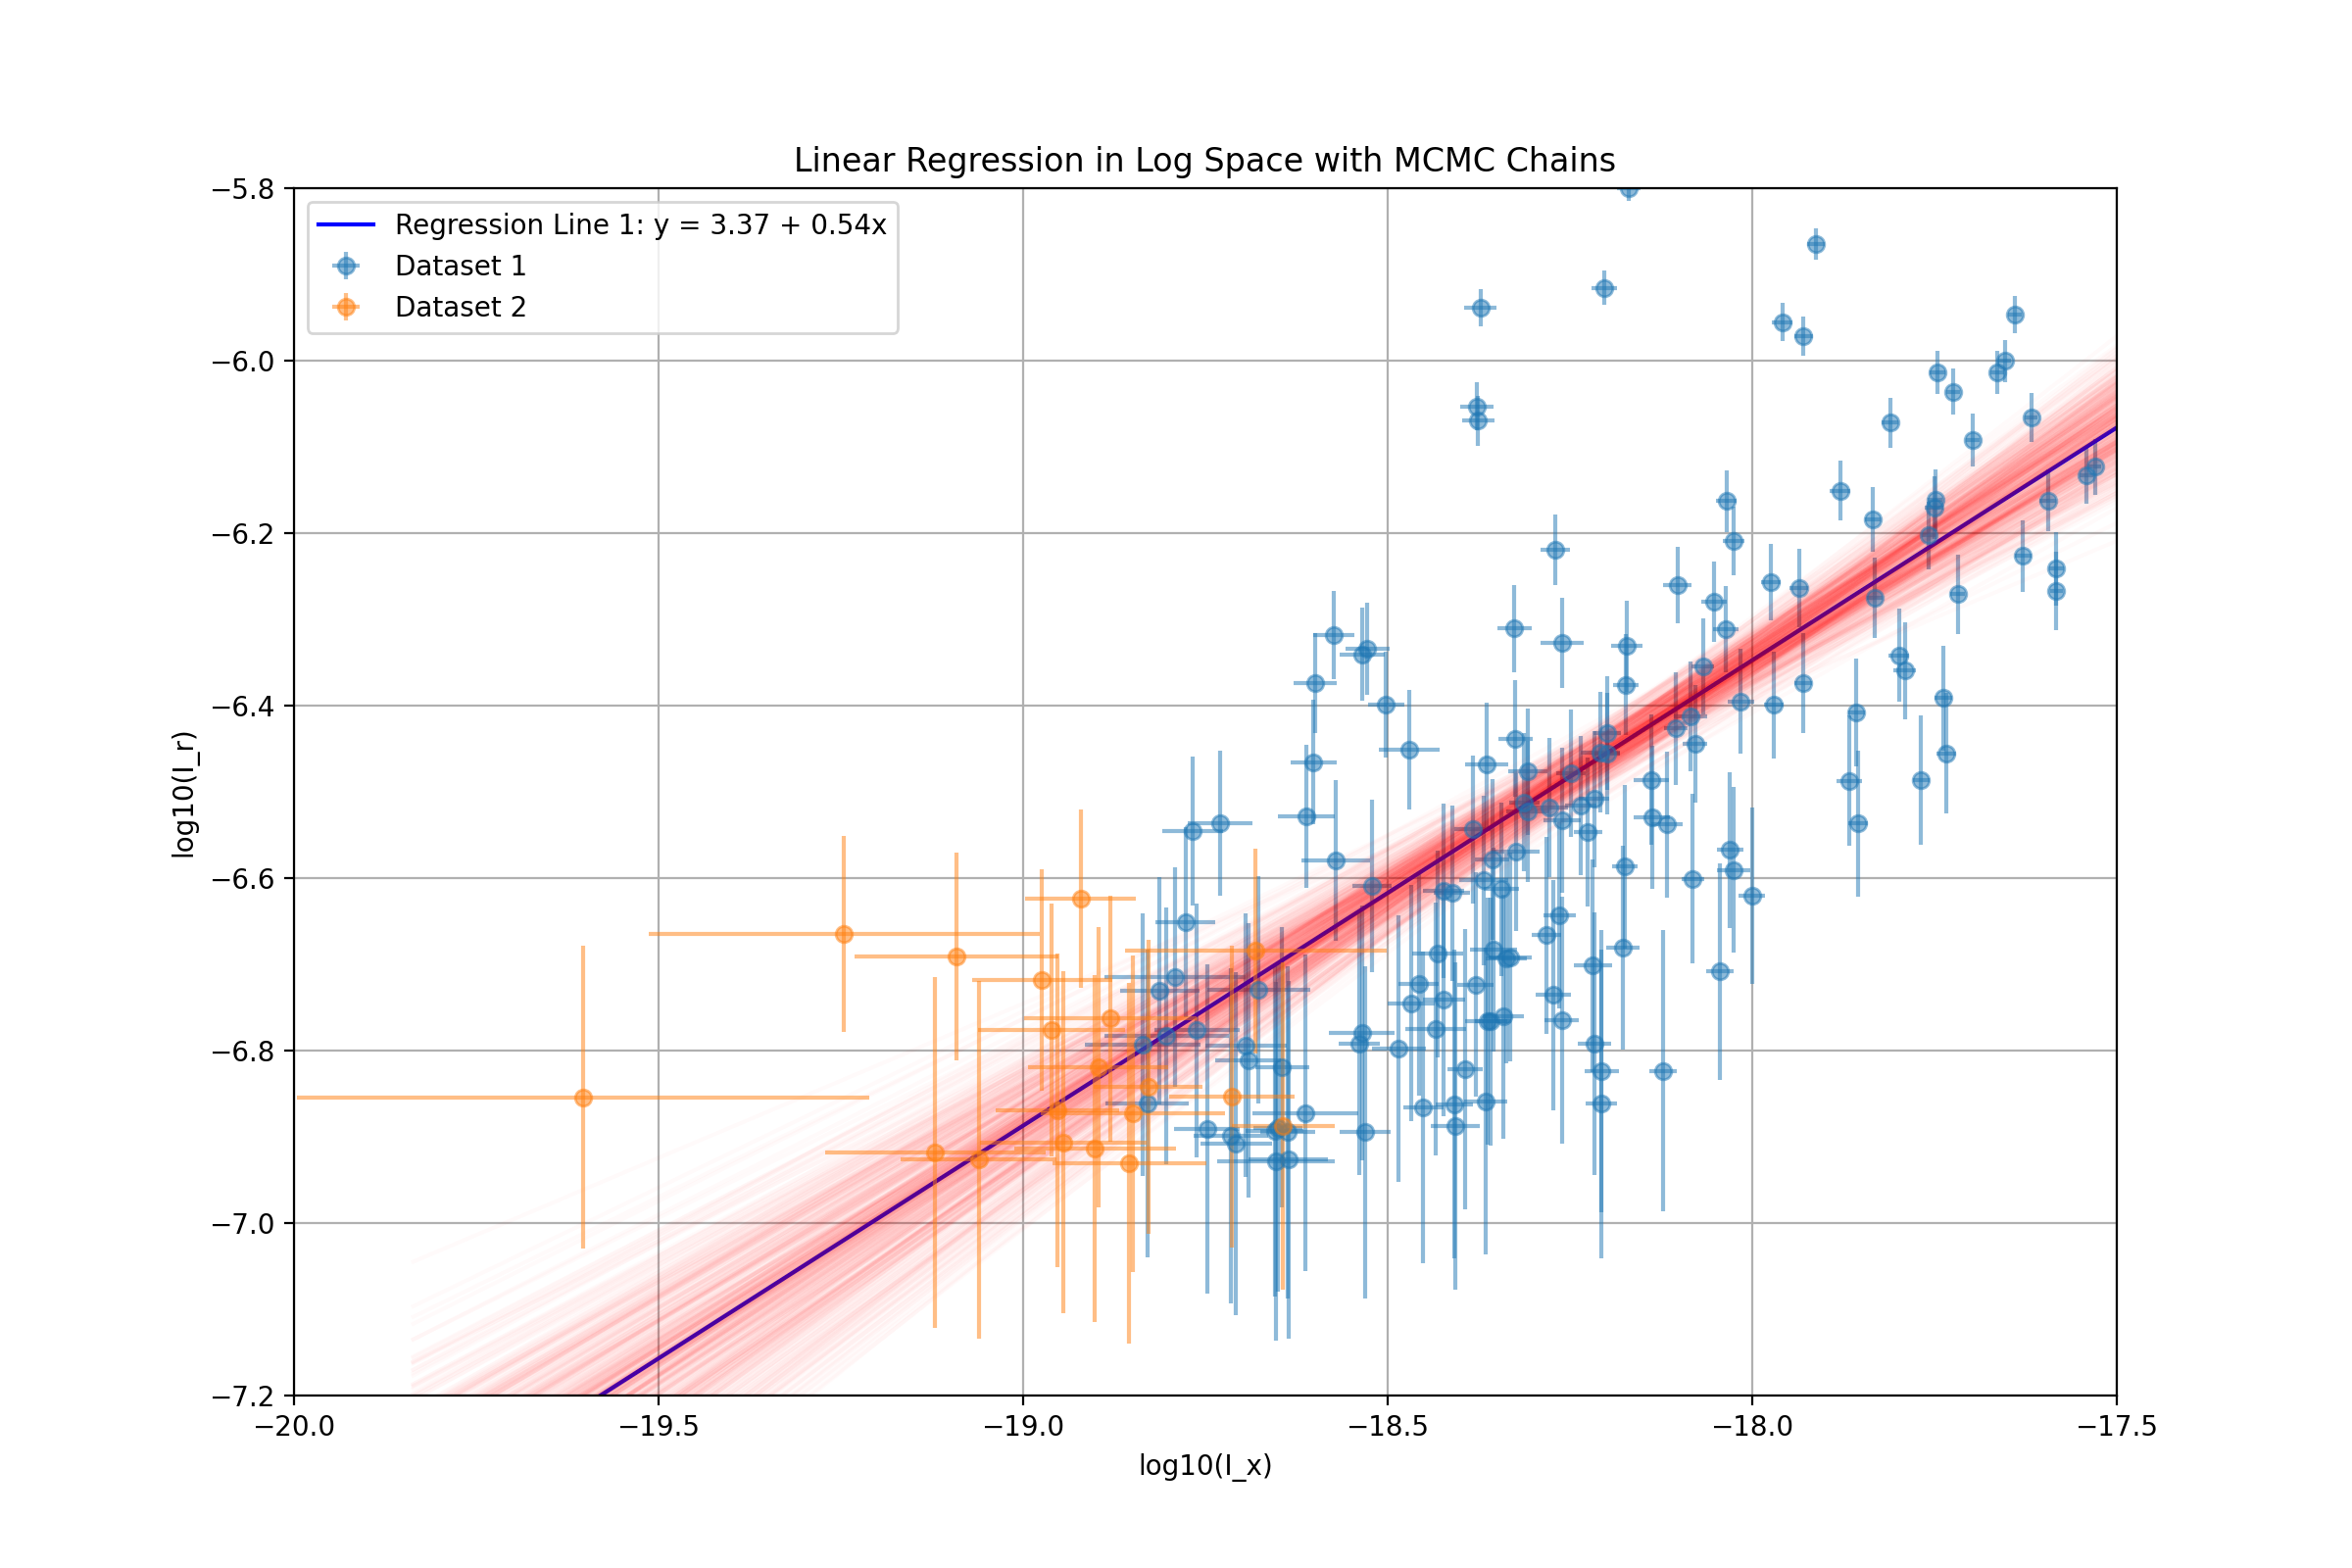

Dataset 1 - Pearson correlation: 0.68, Spearman correlation: 0.70
Dataset 1 - Best fit beta: 0.54 ± 0.05
Dataset 2 - Pearson correlation: -0.06, Spearman correlation: -0.06
Dataset 2 - Best fit beta: -20.61 ± 378.84


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import linmix
%matplotlib notebook

filename1 = "epic_files/filtered_brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061.dat"
data1 = np.loadtxt(filename1)
I_r1 = data1[:, 0]
I_r_err1 = data1[:, 2]
I_x1 = data1[:, 1]
I_x_err1 = data1[:, 3]

lm1 = linmix.LinMix(np.log10(I_x1), np.log10(I_r1), I_x_err1/(np.log(10)*I_x1), I_r_err1/(np.log(10)*I_r1))
lm1.run_mcmc(silent=True)

filename2 = "epic_files/brightnesses_larger_x1.0-2sigmaPSZ2G048.10+57.16-A2061-bridge.dat"
data2 = np.loadtxt(filename2)
I_r2 = data2[:, 0]
I_r_err2 = data2[:, 2]
I_x2 = data2[:, 1]
I_x_err2 = data2[:, 3]

lm2 = linmix.LinMix(np.log10(I_x2), np.log10(I_r2), I_x_err2/(np.log(10)*I_x2), I_r_err2/(np.log(10)*I_r2))
lm2.run_mcmc(silent=True)

def extract_regression_parameters(lm):
    chain = lm.chain
    alpha = chain['alpha'].mean()  # Intercept
    beta = chain['beta'].mean()  # Slope
    beta_std = chain['beta'].std()  # Slope error
    return alpha, beta, beta_std

alpha1, beta1, beta1_std = extract_regression_parameters(lm1)
alpha2, beta2, beta2_std = extract_regression_parameters(lm2)

# Calculate correlation coefficients
pearson_corr1, _ = stats.pearsonr(np.log10(I_x1), np.log10(I_r1))
spearman_corr1, _ = stats.spearmanr(np.log10(I_x1), np.log10(I_r1))

pearson_corr2, _ = stats.pearsonr(np.log10(I_x2), np.log10(I_r2))
spearman_corr2, _ = stats.spearmanr(np.log10(I_x2), np.log10(I_r2))

plt.figure(figsize=(12, 8))

plt.errorbar(np.log10(I_x1), np.log10(I_r1), xerr=I_x_err1/(np.log(10)*I_x1), yerr=I_r_err1/(np.log(10)*I_r1), fmt='o', label='Dataset 1', alpha=0.5)

x_vals1 = np.linspace(np.log10(I_x1.min()*1e-1), np.log10(I_x1.max()*1e1), 100)
y_vals1 = alpha1 + beta1 * x_vals1
plt.plot(x_vals1, y_vals1, label=f'Regression Line 1: y = {alpha1:.2f} + {beta1:.2f}x', color='blue')

for i in range(0, len(lm1.chain), 25):
    xs = np.linspace(I_x1.min()*1e-1, I_x1.max()*1e1, 100)
    ys = 10**(lm1.chain[i]['alpha'] + np.log10(xs) * lm1.chain[i]['beta'])
    plt.plot(np.log10(xs), np.log10(ys), color='red', alpha=0.02)

plt.errorbar(np.log10(I_x2), np.log10(I_r2), xerr=I_x_err2/(np.log(10)*I_x2), yerr=I_r_err2/(np.log(10)*I_r2), fmt='o', label='Dataset 2', alpha=0.5)

x_vals2 = np.linspace(np.log10(I_x2.min()), np.log10(I_x2.max()), 100)
y_vals2 = alpha2 + beta2 * x_vals2
#plt.plot(x_vals2, y_vals2, label=f'Regression Line 2: y = {alpha2:.2f} + {beta2:.2f}x', color='green')

#for i in range(0, len(lm2.chain), 25):
#    xs = np.linspace(I_x2.min(), I_x2.max(), 100)
#    ys = 10**(lm2.chain[i]['alpha'] + np.log10(xs) * lm2.chain[i]['beta'])
#    plt.plot(np.log10(xs), np.log10(ys), color='orange', alpha=0.02)

plt.xlabel('log10(I_x)')
plt.ylabel('log10(I_r)')
plt.xlim(-20,-17.5)
plt.ylim(-7.2, -5.8)
plt.legend()
plt.title('Linear Regression in Log Space with MCMC Chains')
plt.grid(True)
plt.show()

print(f"Dataset 1 - Pearson correlation: {pearson_corr1:.2f}, Spearman correlation: {spearman_corr1:.2f}")
print(f"Dataset 1 - Best fit beta: {beta1:.2f} ± {beta1_std:.2f}")

print(f"Dataset 2 - Pearson correlation: {pearson_corr2:.2f}, Spearman correlation: {spearman_corr2:.2f}")
print(f"Dataset 2 - Best fit beta: {beta2:.2f} ± {beta2_std:.2f}")

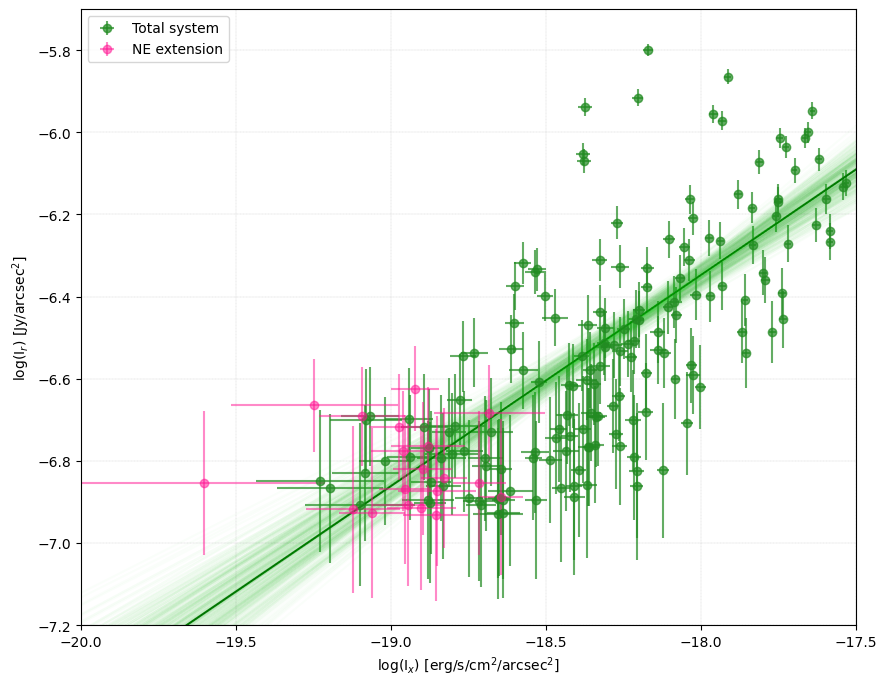

Dataset 1 - Pearson correlation: 0.71, Spearman correlation: 0.73
Dataset 1 - Best fit beta: 0.51 ± 0.05
Dataset 2 - Pearson correlation: -0.06, Spearman correlation: -0.06
Dataset 2 - Best fit beta: -0.21 ± 0.79
19


In [39]:
# Plot the data points and regression lines
plt.figure(figsize=(10, 8))

# Plot the first dataset and regression lines
plt.errorbar(np.log10(I_x1), np.log10(I_r1), xerr=I_x_err1/(np.log(10)*I_x1), yerr=I_r_err1/(np.log(10)*I_r1), fmt='o', 
             label='Total system', color='forestgreen', alpha=0.7)

x_vals1 = np.linspace(np.log10(I_x1.min()*1e-1), np.log10(I_x1.max()*1e1), 100)
y_vals1 = alpha1 + beta1 * x_vals1
plt.plot(x_vals1, y_vals1, color='darkgreen') #label=f'Ir = {alpha1:.2f} + {beta1:.2f}Ix')

# Plot the first set of chains
for i in range(0, len(lm1.chain), 25):
    xs = np.linspace(I_x1.min()*1e-1, I_x1.max()*1e1, 100)
    ys = 10**(lm1.chain[i]['alpha'] + np.log10(xs) * lm1.chain[i]['beta'])
    plt.plot(np.log10(xs), np.log10(ys), color='limegreen', alpha=0.02)

# Plot the second dataset and regression lines
plt.errorbar(np.log10(I_x2), np.log10(I_r2), xerr=I_x_err2/(np.log(10)*I_x2), yerr=I_r_err2/(np.log(10)*I_r2), fmt='o', 
             label='NE extension', color='deeppink', alpha=0.5)

x_vals2 = np.linspace(np.log10(I_x2.min()), np.log10(I_x2.max()), 100)
y_vals2 = alpha2 + beta2 * x_vals2
#plt.plot(x_vals2, y_vals2, label=f'Regression Line 2: y = {alpha2:.2f} + {beta2:.2f}x', color='green')

# Plot the second set of chains
#for i in range(0, len(lm2.chain), 25):
#    xs = np.linspace(I_x2.min(), I_x2.max(), 100)
#    ys = 10**(lm2.chain[i]['alpha'] + np.log10(xs) * lm2.chain[i]['beta'])
#    plt.plot(np.log10(xs), np.log10(ys), color='orange', alpha=0.02)

# Plot settings
plt.xlabel(r'log(I$_{x}$) [erg/s/cm$^{2}$/arcsec$^{2}$]')
plt.ylabel(r'log(I$_{r}$) [Jy/arcsec$^{2}$]')
plt.xlim(-20,-17.5)
plt.ylim(-7.2, -5.7)
plt.legend(loc='upper left')
#plt.title('Linear Regression in Log Space with MCMC Chains')
plt.grid(linewidth=0.2, linestyle='--')
plt.savefig('composite_image_final/pointopoint.pdf')

plt.show()

# Print correlation coefficients and best fit parameters with errors
print(f"Dataset 1 - Pearson correlation: {pearson_corr1:.2f}, Spearman correlation: {spearman_corr1:.2f}")
print(f"Dataset 1 - Best fit beta: {beta1:.2f} ± {beta1_std:.2f}")

print(f"Dataset 2 - Pearson correlation: {pearson_corr2:.2f}, Spearman correlation: {spearman_corr2:.2f}")
print(f"Dataset 2 - Best fit beta: {beta2:.2f} ± {beta2_std:.2f}")

print(len(I_r2))

### Additional tests and masking ad hoc

In [38]:
f = fits.open('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-relic.fits')[0]
data=f.data
header=f.header
mask_data = np.ones_like(data)

region_list = pyregion.open('imaging/MFS-images/outside_r500.reg')
    
reg_list = region_list.as_imagecoord(f.header)
    
mask = reg_list.get_mask(shape=data.shape)
    
mask_data[mask] = np.nan
masked_data = np.multiply(mask_data, data)
fits.writeto('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-r500.fits',
              masked_data, header, overwrite=True)


In [25]:
import numpy as np

# Open the file
with open('imaging/MFS-images/radial_profile_2.txt', 'r') as f:
    # Skip lines until you reach the actual data
    for line in f:
        if line.strip().startswith('#---'):
            break
    
    # Initialize empty lists to store the data
    data = [[] for _ in range(10)]  
    
    # Read the data line by line
    for line in f:
        # Split the line by whitespace
        parts = line.strip().split()
        # Convert each part to float and append to the corresponding list
        for i, part in enumerate(parts[1:]):  # Skip the first column (which is a number)
            data[i].append(float(part))

# Convert lists to numpy arrays
arrays = [np.array(column) for column in data]

summ2=arrays[0]
npix2=arrays[1]
center_ra=230.31884
center_dec=30.668956
n_anuli=15
beam_area=np.pi*80*80/(4*np.log(2))
rms=4e-4/beam_area

In [ ]:
import numpy as np
import pyregion
from astropy.io import fits
from astropy.wcs import WCS
import os


# Function to create a mask fits file
regions_boxes = pyregion.open('imaging/MFS-images/box_ellipses_annuli.reg')

# Read fits file to get header and WCS
hdul = fits.open('imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-relic.fits')
header = hdul[0].header
data=hdul[0].data
mask_data = np.zeros_like(data)

# Iterate over each region and update mask
output_directory = './masks_ellipses/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over each ellipse region
box = regions_boxes.as_imagecoord(header)
mask_box = np.invert(box.get_mask(shape=data.shape))

for i in range(1, 10):
    region_file = os.path.join('masks_ellipses', f'ellipses_annuli_{i}.reg')
    regions_ellipse = pyregion.open(region_file)
    ellipse = regions_ellipse.as_imagecoord(header)
    mask_el = ellipse.get_mask(shape=data.shape)
    mask_tot = np.multiply(mask_el, mask_box)

    # Construct the output file name using string formatting
    output_file = os.path.join(output_directory, f'ellipse_annulus_mask_{i}.fits')

    # Write mask to fits file

    fits.writeto(output_file, mask_tot.astype('float32'), header, overwrite=True)

### Comparison between model and observed data

In [25]:
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import pyregion
from astropy.io import fits
from astropy.wcs import WCS
import os

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define the model function
def intensity(x, y, w, I0, x0, y0, r1):
    z=0.078
    scale=1.41
    # Get pixel coordinates where mask is 1
    r1=r1/scale/7
    
    coord_pix= w.wcs_world2pix(x0, y0, 0)   
    xc=coord_pix[0]
    yc=coord_pix[1]
    
    r2= (x-xc)**2 + (y-yc)**2
    return I0 * np.exp(-np.sqrt(abs(r2)/r1**2))

# Function to compute mean intensity for each realization
def compute_mean_intensity(mask_file, parameters):
    # Read mask fits file
    mask_data, header = fits.getdata(mask_file, header=True)

    # Extract WCS information
    wcs = WCS(header)

    y, x = np.where(mask_data == 1)

    # Compute intensity for each pixel
    intensities = intensity(x, y, wcs, **parameters)

    # Compute mean intensity over the mask
    mean_intensity = np.mean(intensities)

    return mean_intensity

mask_directory = './masks_ellipses/'
mask_files = [os.path.join(mask_directory, f'ellipse_annulus_mask_{i}.fits') for i in range(1, 10)]

final_mean_intensities = []
final_stds_intensities = []

for mask_file in mask_files:

    n_realizations = 500
    parameter_values = {
        'I0': np.random.normal(1.77e-6, 0.03e-6, n_realizations),
        'x0': np.random.normal(230.33, 0.0015, n_realizations),
        'y0': np.random.normal(30.68, 0.0017, n_realizations),
        'r1': np.random.normal(280, 6.1, n_realizations),
    }
    #print(parameter_values)
    # Compute mean intensity for each realization
    mean_intensities = []
    for realization in range(n_realizations):
        realization_parameters = {key: parameter_values[key][realization] for key in parameter_values}
        realization_mean_intensity = compute_mean_intensity(mask_file, realization_parameters)
        mean_intensities.append(realization_mean_intensity)

    # Compute mean and standard deviation of mean intensities
    final_mean_intensity = np.mean(mean_intensities)
    final_std_intensity = np.std(mean_intensities)
    final_mean_intensities.append(final_mean_intensity)
    final_stds_intensities.append(final_std_intensity)

In [31]:
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define the model function
def intensity(x, y, w, I0, x0, y0, r1, r2, d):
    z=0.078
    scale=1.41
    # Get pixel coordinates where mask is 1
    r1=r1/scale/7
    r2=r2/scale/7
    
    coord_pix= w.wcs_world2pix(x0, y0, 0)   
    xc=coord_pix[0]
    yc=coord_pix[1]
    
    delta_x = ((x-xc)*np.cos(d)+(y-yc)*np.sin(d))
    delta_y = (-(x-xc)*np.sin(d)+(y-yc)*np.cos(d))
 
    return I0 * np.exp(-np.sqrt((delta_x / r1) ** 2 + (delta_y / r2) ** 2))

# Function to compute mean intensity for each realization
def compute_mean_intensity(mask_file, parameters):
    # Read mask fits file
    mask_data, header = fits.getdata(mask_file, header=True)

    # Extract WCS information
    wcs = WCS(header)

    y, x = np.where(mask_data == 1)

    # Compute intensity for each pixel
    intensities = intensity(x, y, wcs, **parameters)

    # Compute mean intensity over the mask
    mean_intensity = np.mean(intensities)

    return mean_intensity

mask_directory = './masks_ellipses/'
mask_files = [os.path.join(mask_directory, f'ellipse_annulus_mask_{i}.fits') for i in range(1, 10)]

final_mean_intensities = []
final_stds_intensities = []

for mask_file in mask_files:

    n_realizations = 500
    parameter_values = {
        'I0': np.random.normal(1.85e-6, 0.03e-6, n_realizations),
        'x0': np.random.normal(230.33, 0.0015, n_realizations),
        'y0': np.random.normal(30.68, 0.0017, n_realizations),
        'r1': np.random.normal(418.7, 8.2, n_realizations),
        'r2': np.random.normal(212.7, 4.4, n_realizations),
        'd':np.random.normal(2.14, 1.8e-2, n_realizations)
    }
    #print(parameter_values)
    # Compute mean intensity for each realization
    mean_intensities = []
    for realization in range(n_realizations):
        realization_parameters = {key: parameter_values[key][realization] for key in parameter_values}
        realization_mean_intensity = compute_mean_intensity(mask_file, realization_parameters)
        mean_intensities.append(realization_mean_intensity)

    # Compute mean and standard deviation of mean intensities
    final_mean_intensity = np.mean(mean_intensities)
    final_std_intensity = np.std(mean_intensities)
    final_mean_intensities.append(final_mean_intensity)
    final_stds_intensities.append(final_std_intensity)

In [33]:
import numpy as np

# Open the file
with open('imaging/MFS-images/radial_profile_new.txt', 'r') as f:
    # Skip lines until you reach the actual data
    for line in f:
        if line.strip().startswith('#---'):
            break
    
    # Initialize empty lists to store the data
    data = [[] for _ in range(11)]  
    
    # Read the data line by line
    for line in f:
        # Split the line by whitespace
        parts = line.strip().split()
        # Convert each part to float and append to the corresponding list
        for i, part in enumerate(parts[0:]):
            data[i].append(float(part))

# Convert lists to numpy arrays
arrays = [np.array(column) for column in data]

rad=arrays[0]
summ1=arrays[1]
npix1=arrays[2]

beam_area=np.pi*80*80/(4*np.log(2))
rms=4e-4/ beam_area
print(beam_area)
print(summ1)

7251.77622692351
[1.9580665 4.1763871 3.5528956 3.2131385 2.7635375 2.6351977 2.518456
 2.0429591 1.305804 ]


[1.33669300e-06 1.11179980e-06 6.49780548e-07 3.34402236e-07
 2.11126993e-07 2.00323328e-07 1.34295498e-07 9.40001475e-08
 5.91740982e-08]


<IPython.core.display.Javascript object>


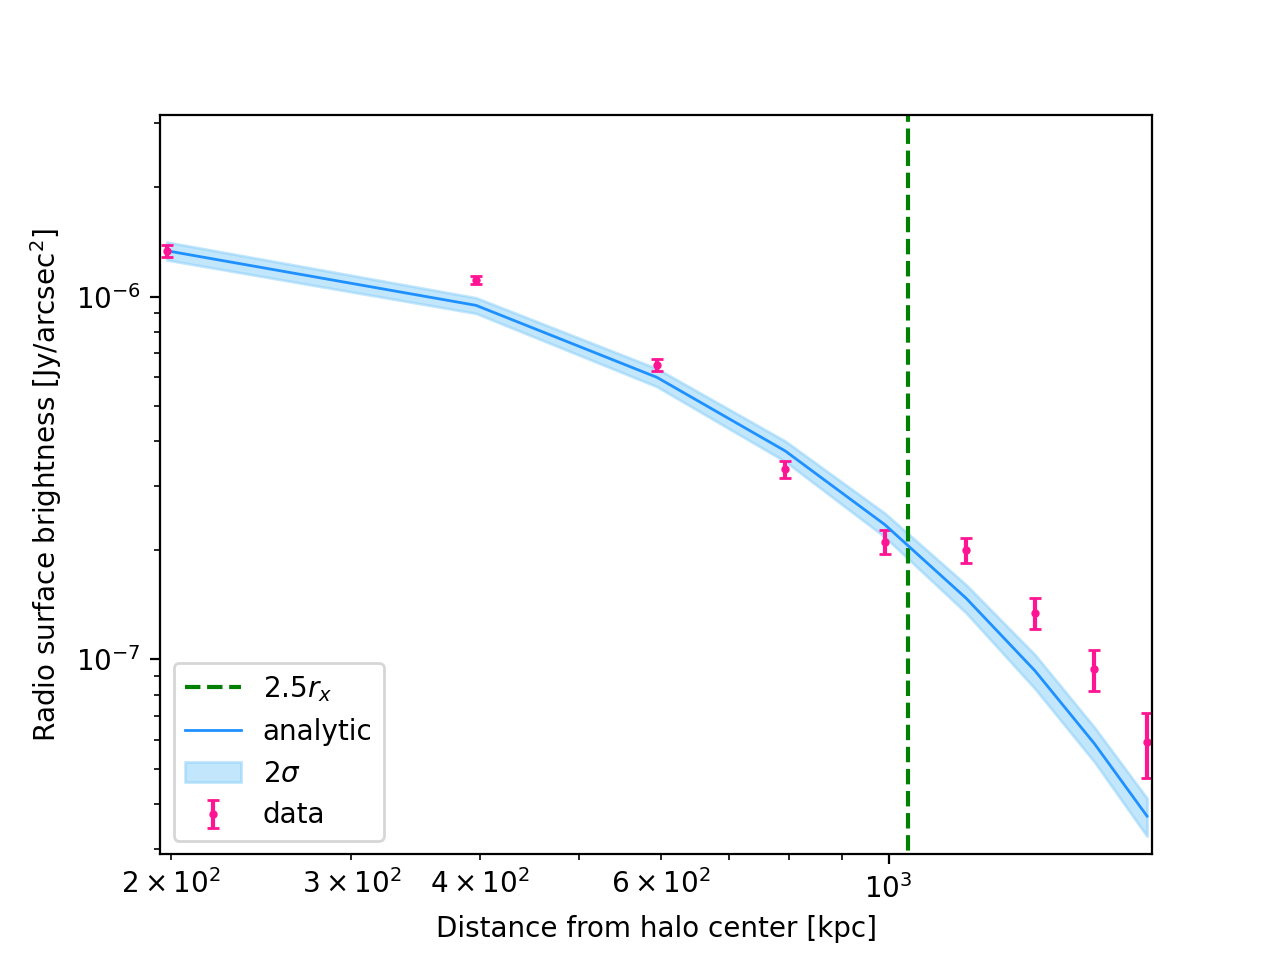

In [34]:
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib notebook

dr=20.
sb_anuli1= (summ1/npix1) / beam_area
sb_anuli_err1 = rms / np.sqrt(npix1*49/beam_area)

print(sb_anuli1)

r=rad*dr
r_data_kpc=85*7*r/60


#r_armin=np.linspace(0,21.0,9)
#r_kpc=r_armin*85
#ry_kpc=r_kpc/2.1

plt.errorbar(r_data_kpc, sb_anuli1, yerr=sb_anuli_err1, fmt='o', markersize=2, capsize=2, color='deeppink', label='data')

#plt.vlines(11*85, 1e-10, 1e-5, linestyles='dashed', color='grey')
plt.vlines(2.5*418, 1e-10, 1e-5, linestyles='dashed', color='green', label=r'$2.5r_{x}$')

plt.plot(r_data_kpc, np.array(final_mean_intensities), color='dodgerblue', linewidth=1, label='analytic')
plt.fill_between(r_data_kpc, (np.array(final_mean_intensities)+2*np.array(final_stds_intensities)), (np.array(final_mean_intensities)-2*np.array(final_stds_intensities)), alpha=0.5, 
                 color='lightskyblue', label=r'$2\sigma$')


plt.yscale('log')
plt.xscale('log')
plt.ylim(2.9e-8,1*10**-5.5)
plt.xlim(min(r_data_kpc)-3,max(r_data_kpc)+20)

plt.xlabel('Distance from halo center [kpc]')
plt.ylabel(r'Radio surface brightness [Jy/arcsec$^2$]')
plt.legend(loc='lower left')
plt.show()
#plt.savefig('halo_bridge_fit.pdf')


In [21]:
#Reads the input file (infile), and subtracts the average profile found by HALO_FDCA. Returna a fits file with the residuals after subtraction of the aerage profile
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

#image from which you want to subtract an average profile
infile='./imaging/MFS-images/A2061_A2067_sourcesub_taper70_briggs05-MFS-image-pb-masked-relic.fits'
#infile='image_allMS_SHI_FTh_Scale1000_no0scale_4_mask_35asec.int.restored.fits'
#infile='../LARRY/COMA_DIFF_blank.FITS'

#parameters of the analytic profile to subtract
#re not used!!!!!!!!!!!!!!!!!!!!!!!!!
re=310.479651  #in kpc

r1=463.4
r2=220.7

I0=1.58e-6   #in Jy/arcsec^2 NOTE: on image not corrected for LOTSS flux
xc_deg=230.36
yc_deg=30.63

scale=1.41 #kpc/arcsec

#*********end inputs ************

#read header and take relevant parameters

hdul = fits.open(infile)
hdr=hdul[0].header 

observed=hdul[0].data

obs=np.squeeze(observed)

ax_x=hdr['NAXIS1']  
ax_y=hdr['NAXIS2']  

cell=hdr['CDELT2']*60.*60. 

#convert re, xc_deg, yc_deg in pixels, convert I0 in muJy/beam
re=re/scale/cell
r1=r1/scale/cell
r2=r2/scale/cell



w = WCS(hdul[0].header)
coord_res= w.wcs_world2pix(xc_deg, yc_deg,0)   

x_c=coord_res[0]
y_c=coord_res[1]
bmaj=hdr['BMAJ']*60.*60.
bmin=hdr['BMIN']*60.*60.
beam_arcsec=2*np.pi/(8*np.log(2))*bmaj*bmin

I0=I0*beam_arcsec

kernel = Gaussian2DKernel(x_stddev=bmaj/cell/2.35) # Gaussian with FWHM=beam (FWHM=2.35 stddev)

analytic=np.zeros((ax_y,ax_x))
residual=np.zeros((ax_y,ax_x))

for yy in range (0, ax_y-1):
    for xx in range (0,ax_x-1):
        delta_x = ((xx-x_c)*np.cos(2.14)+(yy-y_c)*np.sin(2.14))
        delta_y = (-(xx-x_c)*np.sin(2.14)+(yy-y_c)*np.cos(2.14))

        G=(((delta_x)/(r1))**2+((delta_y)/(r2))**2)
        #rr=np.sqrt((xx-x_c)**2.+(yy-y_c)**2.)
        analytic[yy,xx]=I0*np.exp(-1.*G**0.5)
        residual[yy,xx]=obs[yy,xx]-analytic[yy,xx]
        obs[yy,xx]=obs[yy,xx]

analytic_conv=convolve(analytic,kernel)

hdu_out=fits.PrimaryHDU(analytic_conv)
hdu_out.header=hdr  
hdu_out.writeto(infile.replace('.fits','_analytic.fits'), overwrite=True)

#residual=obs/beam_arcsec-analytic_conv



/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


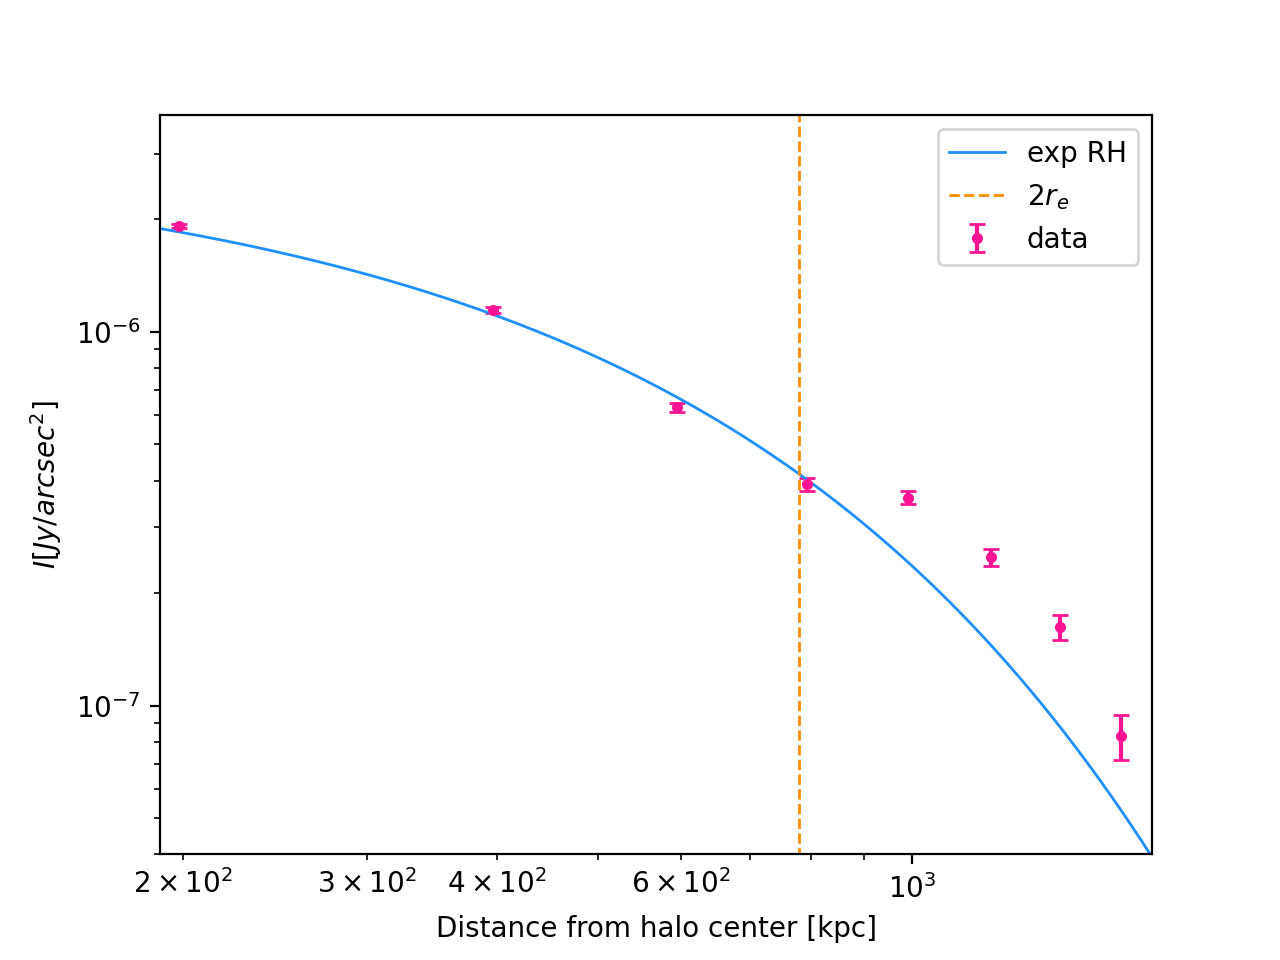

In [98]:
import numpy as np
%matplotlib notebook
# Open the file
with open('imaging/MFS-images/radial_profile_4.txt', 'r') as f:
    # Skip lines until you reach the actual data
    for line in f:
        if line.strip().startswith('#---'):
            break
    
    # Initialize empty lists to store the data
    data = [[] for _ in range(10)]  
    
    # Read the data line by line
    for line in f:
        # Split the line by whitespace
        parts = line.strip().split()
        # Convert each part to float and append to the corresponding list
        for i, part in enumerate(parts[0:]):  # Skip the first column (which is a number)
            data[i].append(float(part))

# Convert lists to numpy arrays
arrays = [np.array(column) for column in data]

rad=arrays[0]
summ1=arrays[1]
npix1=arrays[2]

beam_area=np.pi*80*80/(4*np.log(2))

#rms=4e-4/beam_area


#Fit a double exponential profile on txt files computed from images - it would be better to do it on the deconvoled images (fit_gauss_deconv.py in this directory) but doesn't work
import scipy.optimize as opt
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



def GaussExp(r_data, I0,re,Ig,sigmaG):
     return I0*np.exp(-r_data/re)+Ig*np.exp(-r_data**2/(2.*sigmaG**2))

#file_stat='VLA_5arcsec_sectorN.stat'
#file_stat='LOFAR_BassaRes_statCircle.txt'

#dr of shells in pixels
#dr=4.357
dr=20.
#beam area in pixels
beam_pix=beam_area/49

I_fit=summ1/npix1
#sigma_fit=np.array([2.69926496e-08, 2.09389323e-08, 1.79020016e-08, 1.57507573e-08, 1.43128431e-08])


#rad,npix,f_mean,f_std=np.loadtxt(file_stat,comments='#',usecols=(0,2,3,8),unpack=True,skiprows=16)

rms=4e-4

#bounds=([-np.inf,4,-np.inf,4],np.inf) 

r_data=rad*dr
r_data1=r_data[0:5]
I_data=I_fit
I_data1=I_data[0:5]
I_err=rms/np.sqrt(npix1/beam_pix)
I_err1=I_err[0:5]

popt, pcov = curve_fit(GaussExp, r_data1, I_data1,sigma=I_err1)

I0_fit=popt[0]
re_fit=popt[1]
Ig_fit=popt[2]
sigmaG_fit=popt[3]


plt.figure() 

r_data_kpc=85*7*r_data/60
re_kpc=85*7*re_fit/60
re_kpc=390
I_data_phys=I_data/beam_area
I_err_phys=I_err/beam_area
I0_fit_phys=I0_fit/beam_area

r_data_kpc_fit=np.linspace(0,2000,1000)

plt.errorbar(r_data_kpc, I_data_phys, yerr=I_err_phys, fmt='o',color='deeppink',label='data', markersize=3, capsize=3)
plt.plot(r_data_kpc_fit,I0_fit_phys*np.exp(-r_data_kpc_fit/re_kpc), color='dodgerblue',label='exp RH', linewidth=1)
#plt.errorbar(r_data,Ig_fit*np.exp(-r_data**2/(2.*sigmaG_fit**2)), color='green',label='Gauss AGN')
plt.vlines(2*re_kpc, 1e-10, 1e-5, linestyles='dashed', color='darkorange', label=r'$2r_{e}$', linewidth=1)
plt.xlim(190,1700)
plt.ylim(4e-8,3.8e-6)

plt.xscale('log')
plt.yscale('log')

plt.legend()  


plt.xlabel('Distance from halo center [kpc]')
plt.ylabel(r'$I [Jy/arcsec^2]$')
#plt.legend( loc="upper right")


plt.show()
plt.savefig('fit.pdf')


In [32]:
import numpy as np
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_function(r, I0, re):
    return I0 * np.exp(-r / re)

# Given data
I_fit = np.array([4.26485268e-07, 4.61530240e-07, 4.01881170e-07, 2.74608675e-07, 1.76914706e-07])
rmean_fit = np.array([156.8452381, 322.65306122, 488.46088435, 654.26870748, 820.07653061])
sigma_fit = np.array([2.69926496e-08, 2.09389323e-08, 1.79020016e-08, 1.57507573e-08, 1.43128431e-08])

# Initial guess for parameters
initial_guess = [I_fit[0], rmean_fit[0]]

# Fit the data to the exponential function
popt, pcov = curve_fit(exponential_function, rmean_fit, I_fit, sigma=sigma_fit, p0=initial_guess)

# Extract the optimal parameters
I0_opt, re_opt = popt

# Print the optimal parameters
print("Optimal parameters:")
print("I0:", I0_opt)
print("re:", re_opt)


Optimal parameters:
I0: 6.350357167017517e-07
re: 772.9497882537299



# Conclusion

This notebook investigated the **correlation between X-ray and radio properties** of astrophysical sources.  

Key outcomes:
- Found significant correlation (quantified with Pearson/Spearman tests)
- Fitted regression models to describe the X-ray vs Radio relation
- Produced clear statistical visualizations of the relationship

---

## Skills Demonstrated
- **Statistical inference** (correlation coefficients, p-values, regression)
- **Uncertainty quantification** with resampling methods
- **Data visualization** of correlations
- **Scientific computing** with Python

This project highlights both **domain expertise (astrophysics)**  
and transferable **data science/statistical analysis skills**.
